In [5]:
import os.path

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
from algbench import read_as_pandas
import re

font = {'family': 'serif', 'size': 11}
matplotlib.rc('font', **font)

matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=[
    "#089099",
    "#F0746E",
    "#27AE60",
])

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['figure.figsize'] = [9, 3.5]

In [2]:
paths = ['classical_qtg_comparison/small', 'classical_qtg_comparison/large']
optimal_solutions = dict()

combo_results = []
ctg_results = []

for path in paths:
    combo_results.append(read_as_pandas(f'results/classical_benchmark/{path}', lambda row: {
        'size': row['parameters']['args']['instance']['size'],
        'elapsed_cycles': row['result']['elapsed_cycles'],
        'elapsed_real_time': (row['result']['elapsed_real_time']),
        'instance': row['parameters']['args']['instance']['name'],
        'objective_value': row['result']['objective_value'],
        'memory_bits': (row['result']['maximum_resident_size_kb'] - 80000) * 8 * 1024,
    } if row['parameters']['args']['solver'] == "combo" else None))

combo_results = pd.concat(combo_results)

for i, row in combo_results.iterrows():
    optimal_solutions[row['instance']] = row['objective_value']

for path in paths:
    if not os.path.isdir(f'results/ctg/{path}/results'):
        continue

    ctg_results.append(read_as_pandas(f'results/ctg/{path}', lambda row: {
        'algorithm': 'ctg',
        'algorithm_human_readable': 'CTG',
        'elapsed_cycles': np.average(row['result']['elapsed_cycles']),
        'qtg_estimate_cycles': np.average(
            [it * row['result']['qtg_cycles'] for it in row['result']['total_iterations']]),
        'qtg_estimate_memory_bits': row['parameters']['args']['instance']['size'] +
                                    np.log2(row['parameters']['args']['instance']['capacity']) +
                                    np.log2(optimal_solutions[row['parameters']['args']['instance']['name']]) +
                                    max(row['parameters']['args']['instance']['size'],
                                        np.log2(row['parameters']['args']['instance']['capacity']),
                                        np.log2(optimal_solutions[row['parameters']['args']['instance']['name']])
                                        ) + 1,
        #n + log2(Z) + log2(OPT) + max(n, log2(Z), log2(OPT)) +1
        'success_probability': sum([1 for obj in row['result']['objective_values'] if
                                    obj == optimal_solutions[row['parameters']['args']['instance']['name']]]) / len(
            row['result']['objective_values']),
        'size': row['parameters']['args']['instance']['size'],
        'instance': row['parameters']['args']['instance']['name'],
        'capacity': row['parameters']['args']['instance']['capacity'],
        'max_iter': row['parameters']['args']['alg_params']['max_iter_str'],
        'max_iter_num': row['parameters']['args']['alg_params']['max_iter'],
        'gap': np.average([(optimal_solutions[row['parameters']['args']['instance']['name']] - obj) / optimal_solutions[
            row['parameters']['args']['instance']['name']] for obj in row['result']['objective_values']]),
        'runtime': row['runtime']
    }))

ctg_results = pd.concat(ctg_results)

"""
qtg_results = read_as_pandas(f'results/quantum_benchmark/classical_qtg_comparison', lambda row: {
    'algorithm': 'ctg',
    'algorithm_human_readable': 'CTG',
    'elapsed_cycles': np.average([measure['cycle_count'] for measure in row['result']['measurements']]),
    'success_probability': sum([1 for measure in row['result']['measurements'] if
                                measure['objective_value'] == optimal_solutions[
                                    row['parameters']['args']['instance']['name']]]) / len(
        row['result']['measurements']),
    'memory_bits': np.average([measure['qubit_count'] for measure in row['result']['measurements']]),
    'size': row['parameters']['args']['instance']['size'],
    'instance': row['parameters']['args']['instance']['name'],
    'capacity': row['parameters']['args']['instance']['capacity'],
    'max_iter': row['parameters']['args']['alg_params']['qtg_iterations_str'],
    'runtime': row['runtime'],
})
"""
ctg_results['g'] = ctg_results.apply(
    lambda row: int(re.match(r'.+\_g\_([0-9]+)\_.+', row['instance']).group(1)), axis=1)
combo_results['g'] = combo_results.apply(
    lambda row: int(re.match(r'.+\_g\_([0-9]+)\_.+', row['instance']).group(1)), axis=1)


#qtg_results['g'] = qtg_results.apply(
#    lambda row: int(re.match(r'.+\_g\_([0-9]+)\_.+', row['instance']).group(1)), axis=1)

def g_group(row):
    if row['g'] == 2:
        return "$g=2$"
    elif row['g'] > 2 and row['g'] <= 6:
        return "$3 \\leq g \\leq 6$"
    return "$7 \\leq g \\leq 10$"


ctg_results['g_group'] = ctg_results.apply(g_group, axis=1)

In [3]:
missing_instances = set(combo_results['instance'].unique()) - set(ctg_results['instance'].unique())
#print(qtg_results['g'].unique())
print(missing_instances)

set()


Capacity=10000000000, g=[ 5  6  7  2  3  9  8  4 10], max_iter=700 + n^2 / 16


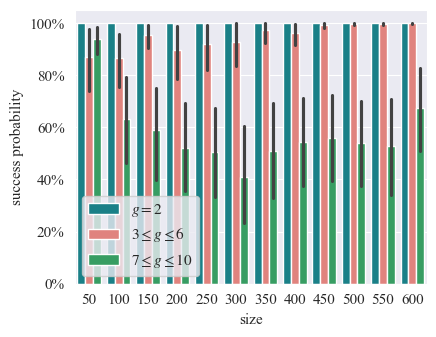

In [7]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(4.5, 3.5))
#sns.lineplot(qtg_results, x='size', y='success_probability', ax=ax, label="QTG")
#sns.lineplot(ctg_results, x='size', y='success_probability', ax=ax, label="CTG")

g_values = list(sorted(combo_results['g'].unique()))

sns.barplot(ctg_results, hue='g_group', hue_order=['$g=2$', '$3 \\leq g \\leq 6$', '$7 \\leq g \\leq 10$'],
            dodge=True, x='size', y='success_probability', ax=ax)

#for g in g_values[5:]: 
#    sns.barplot(ctg_results[ctg_results['g'] == g], x='size', y='success_probability', ax=ax, label=f"g={g}")

#sns.lineplot(qtg_results, x='size', y='success_probability', ax=ax, label="QTG g=2")
ax.set_ylabel("success probability")
# set percentage format
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

ax.legend().set_title(None)

assert len(ctg_results["capacity"].unique()) == 1
assert len(ctg_results["max_iter"].unique()) == 1
print(
    f"Capacity={ctg_results['capacity'].unique()[0]}, g={ctg_results['g'].unique()}, max_iter={ctg_results['max_iter'].unique()[0]}")

fig.tight_layout()
plt.savefig(f"out/08_success_prob.pdf", bbox_inches='tight')

Text(0, 0.5, 'max iterations')

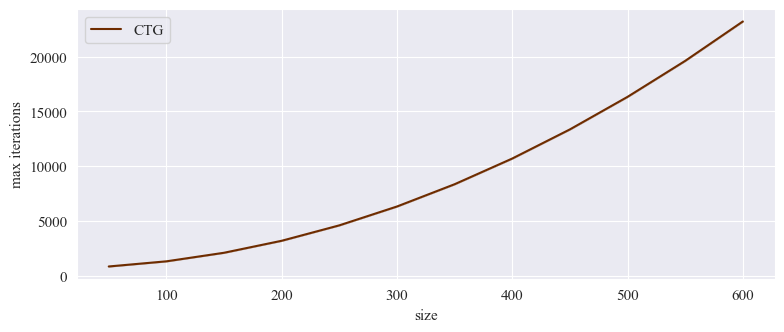

In [11]:
fig, ax = plt.subplots(figsize=(9, 3.5))

sns.lineplot(ctg_results, x='size', y='max_iter_num', ax=ax, label="CTG")
ax.set_ylabel("max iterations")

In [7]:
ctg_results.groupby(['size', 'g']).describe()['success_probability'][['mean', 'max', 'min']]

mean   max   min
size g                       
50   2   1.000000  1.00  1.00
     3   0.998333  1.00  0.99
     4   0.991667  1.00  0.95
     5   0.696667  1.00  0.15
     6   0.786667  1.00  0.03
...           ...   ...   ...
600  6   0.996667  1.00  0.98
     7   0.806667  1.00  0.16
     8   0.826667  1.00  0.02
     9   0.803333  1.00  0.10
     10  0.258333  0.91  0.00

[108 rows x 3 columns]

In [ ]:
ctg_results[ctg_results['g'] == 6].groupby('size').describe()['runtime'][['mean', 'max', 'min']]

In [ ]:
combo_results[combo_results['g'] == 6].groupby('size').describe()['elapsed_real_time'][['mean', 'max', 'min']]

Text(0.5, 1.0, 'Capacity=10000000000, g=[ 3  6  5  4  2  7  8 10  9]')

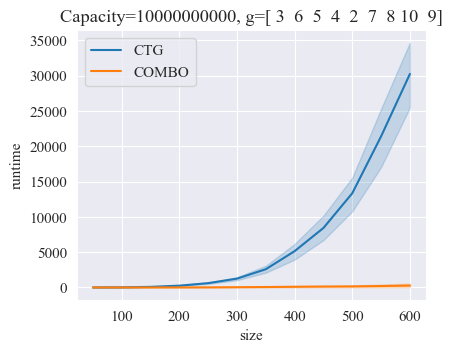

In [19]:
fig, ax = plt.subplots(figsize=(4.5, 3.5))
sns.lineplot(ctg_results, x='size', y='runtime', ax=ax, label="CTG")
sns.lineplot(combo_results, x='size', y='elapsed_real_time', ax=ax, label="COMBO")
ax.set_title(f"Capacity={ctg_results['capacity'].unique()[0]}, g={ctg_results['g'].unique()}")

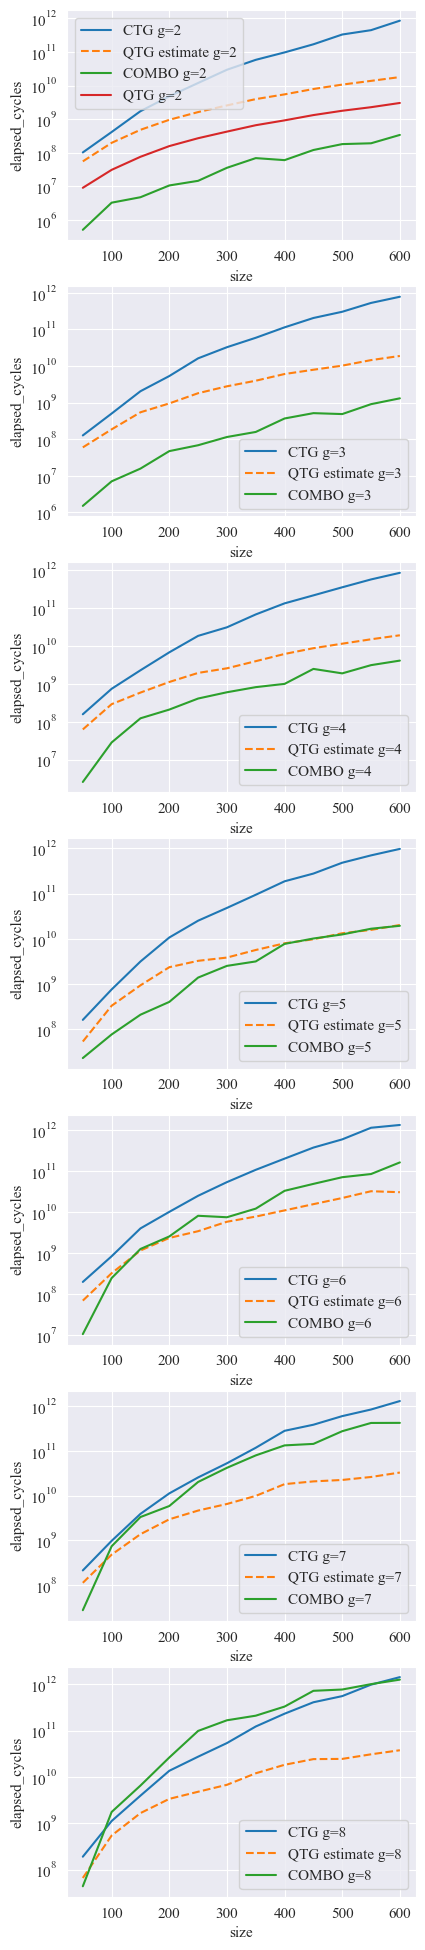

In [190]:
g_values = list(sorted(ctg_results['g'].unique()))
fig, axs = plt.subplots(figsize=(4.5, 3.5 * len(g_values)), nrows=len(g_values))
#sns.lineplot(qtg_results, x='size', y='elapsed_cycles', ax=ax, label="QTG")

for i, g in enumerate(g_values):

    sns.lineplot(ctg_results[ctg_results["g"] == g], x='size',
                 y='elapsed_cycles', ax=axs[i], label=f"CTG g={g}")
    sns.lineplot(ctg_results[ctg_results["g"] == g], x='size',
                 y='qtg_estimate_cycles', ax=axs[i], label=f"QTG estimate g={g}", linestyle='--')
    sns.lineplot(combo_results[combo_results["g"] == g], x='size', y='elapsed_cycles', ax=axs[i], label=f"COMBO g={g}")
    if g == 2:
        sns.lineplot(qtg_results, x='size', y='elapsed_cycles', ax=axs[i], label="QTG g=2")
    #sns.lineplot(combo_results[combo_results["g"] > 4], x='size', y='elapsed_cycles', ax=ax, label="COMBO >4")
    axs[i].set_yscale('log')

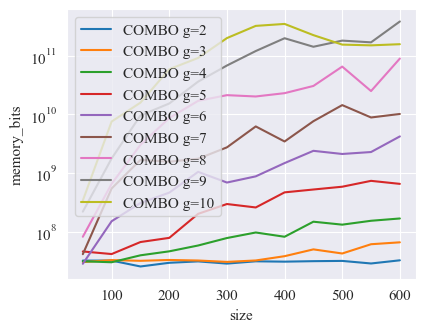

In [13]:
g_values = list(sorted(combo_results['g'].unique()))
fig, ax = plt.subplots(figsize=(4.5, 3.5))

for i, g in enumerate(g_values):
    sns.lineplot(combo_results[combo_results["g"] == g], x='size', y='memory_bits', ax=ax, label=f"COMBO g={g}")

ax.set_yscale('log')